<a href="https://colab.research.google.com/github/StepanTita/nano-BERT/blob/main/imdb_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf nano-BERT
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'nano-BERT'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 20), reused 30 (delta 8), pack-reused 0
Receiving objects: 100% (47/47), 38.31 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (11/11), done.


In [2]:
import sys

sys.path.append('/content/nano-BERT')

In [3]:
import math
import json
from collections import Counter

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from nano_bert.model import NanoBertForClassification
from nano_bert.tokenizer import WordTokenizer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
data = None
with open('nano-BERT/data/imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

In [6]:
vocab = set()
for d in data:
    vocab |= set([w.lower() for w in d['text']])

In [7]:
test_data = None
with open('nano-BERT/data/imdb_test.json') as f:
   test_data = [json.loads(l) for l in f.readlines()]

In [8]:
def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')


class IMDBDataloader:
    def __init__(self, data, test_data, tokenizer, label_encoder, batch_size, val_frac=0.2):
        train_data, val_data = train_test_split(data, shuffle=True, random_state=42, test_size=val_frac)

        self.splits = {
            'train': [d['text'] for d in train_data],
            'test': [d['text'] for d in test_data],
            'val': [d['text'] for d in val_data]
        }

        self.labels = {
            'train': [d['label'] for d in train_data],
            'test': [d['label'] for d in test_data],
            'val': [d['label'] for d in val_data]
        }

        self.tokenized = {
            'train': [tokenizer(record).unsqueeze(0) for record in
                      tqdm(self.splits['train'], desc='Train Tokenization')],
            'test': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['test'], desc='Test Tokenization')],
            'val': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['val'], desc='Val Tokenization')],
        }

        self.encoded_labels = {
            'train': [label_encoder(label) for label in tqdm(self.labels['train'], desc='Train Label Encoding')],
            'test': [label_encoder(label) for label in tqdm(self.labels['test'], desc='Test Label Encoding')],
            'val': [label_encoder(label) for label in tqdm(self.labels['val'], desc='Val Label Encoding')],
        }

        self.curr_batch = 0
        self.batch_size = batch_size
        self.iterate_split = None

    def peek(self, split):
        return {
            'input_ids': self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
            'label_ids': self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
        }

    def take(self, split):
        batch = self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': batch,
            'label_ids': labels,
        }

    def peek_tokenized(self, split):
        return {
            'input_ids': torch.cat(
                self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dim=0),
            'label_ids': torch.tensor(
                self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dtype=torch.long),
        }

    def peek_index_tokenized(self, index, split):
        return {
            'input_ids': torch.cat(
                [self.tokenized[split][index]],
                dim=0),
            'label_ids': torch.tensor(
                [self.encoded_labels[split][index]],
                dtype=torch.long),
        }

    def peek_index(self, index, split):
        return {
            'input_ids': [self.splits[split][index]],
            'label_ids': [self.labels[split][index]],
        }

    def take_tokenized(self, split):
        batch = self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': torch.cat(batch, dim=0),
            'label_ids': torch.tensor(labels, dtype=torch.long),
        }

    def get_split(self, split):
        self.iterate_split = split
        return self

    def steps(self, split):
        return len(self.tokenized[split]) // self.batch_size

    def __iter__(self):
        self.reset()
        return self

    def __next__(self):
        if self.batch_size * self.curr_batch < len(self.splits[self.iterate_split]):
            return self.take_tokenized(self.iterate_split)
        else:
            raise StopIteration

    def reset(self):
        self.curr_batch = 0

In [13]:
NUM_EPOCHS = 200
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-4

In [14]:
tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
tokenizer

Tokenizer[vocab=101522,self.special_tokens=['[PAD]', '[CLS]', '[SEP]', '[UNK]'],self.sep=' ',self.max_seq_len=128]

In [15]:
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|██████████| 5000/5000 [00:00<00:00, 1569607.07it/s]


In [16]:
bert = NanoBertForClassification(
    vocab_size=len(tokenizer.vocab),
    n_layers=1,
    n_heads=1,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=2
).to(device)
bert

NanoBertForClassification(
  (nano_bert): NanoBERT(
    (embedding): BertEmbeddings(
      (word_embeddings): Embedding(101522, 3)
      (pos_embeddings): Embedding(128, 3)
      (layer_norm): LayerNorm((3,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): BertLayer(
          (layer_norm1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
          (self_attention): BertSelfAttention(
            (heads): ModuleList(
              (0): BertAttentionHead(
                (query): Linear(in_features=3, out_features=3, bias=True)
                (key): Linear(in_features=3, out_features=3, bias=True)
                (values): Linear(in_features=3, out_features=3, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (proj): Linear(in_features=3, out_features=3, bias=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
count_parameters(bert)

305123

In [19]:
history = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

In [20]:
optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)

for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    for step, batch in enumerate(tqdm(dataloader.get_split('train'), total=dataloader.steps('train'))):
        logits = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)

        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'))):
        logits = bert(batch['input_ids'].to(device))

        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

        val_loss += loss.item()

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)
    history['train_acc'].append(accuracy_score(train_labels, train_preds))
    history['val_acc'].append(accuracy_score(val_labels, val_preds))
    history['train_f1'].append(f1_score(train_labels, train_preds))
    history['val_f1'].append(f1_score(val_labels, val_preds))

    print()
    print(f'Train loss: {train_loss / dataloader.steps("train")} | Val loss: {val_loss / dataloader.steps("val")}')
    print(f'Train acc: {accuracy_score(train_labels, train_preds)} | Val acc: {accuracy_score(val_labels, val_preds)}')
    print(f'Train f1: {f1_score(train_labels, train_preds)} | Val f1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|██████████| 625/625 [00:06<00:00, 99.99it/s] 
157it [00:00, 532.16it/s]                         



Train loss: 0.6940520731925964 | Val loss: 0.69763744641573
Train acc: 0.50045 | Val acc: 0.497
Train f1: 0.5923870915099344 | Val f1: 0.0
Epoch: 2


100%|██████████| 625/625 [00:03<00:00, 201.27it/s]
157it [00:00, 522.63it/s]                         



Train loss: 0.6937500025749207 | Val loss: 0.697641507937358
Train acc: 0.49545 | Val acc: 0.497
Train f1: 0.503566684705072 | Val f1: 0.0
Epoch: 3


100%|██████████| 625/625 [00:05<00:00, 105.64it/s]
157it [00:00, 299.48it/s]                         



Train loss: 0.6936354717254639 | Val loss: 0.6976346992529355
Train acc: 0.49415 | Val acc: 0.497
Train f1: 0.504481559484743 | Val f1: 0.0
Epoch: 4


100%|██████████| 625/625 [00:05<00:00, 107.01it/s]
157it [00:01, 109.80it/s]                         



Train loss: 0.6931743459701538 | Val loss: 0.6976128637026517
Train acc: 0.503 | Val acc: 0.497
Train f1: 0.5275216275311341 | Val f1: 0.0
Epoch: 5


100%|██████████| 625/625 [00:03<00:00, 167.10it/s]
157it [00:00, 554.85it/s]                         



Train loss: 0.6935556810379029 | Val loss: 0.6976219660196549
Train acc: 0.4982 | Val acc: 0.497
Train f1: 0.5041011957703331 | Val f1: 0.0
Epoch: 6


100%|██████████| 625/625 [00:04<00:00, 149.07it/s]
157it [00:00, 341.37it/s]                         



Train loss: 0.6933747043609619 | Val loss: 0.6976062162564352
Train acc: 0.4985 | Val acc: 0.497
Train f1: 0.4996508031527487 | Val f1: 0.0
Epoch: 7


100%|██████████| 625/625 [00:05<00:00, 107.65it/s]
157it [00:00, 303.81it/s]                         



Train loss: 0.693431032371521 | Val loss: 0.6975851876613421
Train acc: 0.49285 | Val acc: 0.497
Train f1: 0.517895337230857 | Val f1: 0.0
Epoch: 8


100%|██████████| 625/625 [00:04<00:00, 139.49it/s]
157it [00:00, 555.22it/s]                         



Train loss: 0.6933129464149476 | Val loss: 0.6976196544292645
Train acc: 0.50195 | Val acc: 0.497
Train f1: 0.5049450822523731 | Val f1: 0.0
Epoch: 9


100%|██████████| 625/625 [00:03<00:00, 197.23it/s]
157it [00:00, 547.75it/s]                         



Train loss: 0.6931123310089111 | Val loss: 0.6975968495393411
Train acc: 0.5014 | Val acc: 0.497
Train f1: 0.49934732402851695 | Val f1: 0.0
Epoch: 10


100%|██████████| 625/625 [00:05<00:00, 112.53it/s]
157it [00:00, 248.16it/s]                         



Train loss: 0.6933387429237365 | Val loss: 0.697565285059122
Train acc: 0.4992 | Val acc: 0.497
Train f1: 0.4917799878222042 | Val f1: 0.0
Epoch: 11


100%|██████████| 625/625 [00:05<00:00, 124.75it/s]
157it [00:00, 468.90it/s]                         



Train loss: 0.6932361493110657 | Val loss: 0.6975567902509983
Train acc: 0.5018 | Val acc: 0.497
Train f1: 0.48522421988014053 | Val f1: 0.0
Epoch: 12


100%|██████████| 625/625 [00:05<00:00, 121.05it/s]
157it [00:00, 290.21it/s]                         



Train loss: 0.6932064144134521 | Val loss: 0.697536214804038
Train acc: 0.5039 | Val acc: 0.497
Train f1: 0.49346538697161524 | Val f1: 0.0
Epoch: 13


100%|██████████| 625/625 [00:04<00:00, 128.08it/s]
157it [00:00, 256.38it/s]                         



Train loss: 0.6930565218925476 | Val loss: 0.6974998154701331
Train acc: 0.5112 | Val acc: 0.497
Train f1: 0.48362560743714345 | Val f1: 0.0
Epoch: 14


100%|██████████| 625/625 [00:05<00:00, 107.69it/s]
157it [00:00, 308.03it/s]                         



Train loss: 0.6931423545837402 | Val loss: 0.6974439743237618
Train acc: 0.5078 | Val acc: 0.4972
Train f1: 0.4785464561923932 | Val f1: 0.000794912559618442
Epoch: 15


100%|██████████| 625/625 [00:03<00:00, 158.39it/s]
157it [00:00, 552.53it/s]                         



Train loss: 0.6930511940956116 | Val loss: 0.6973770841574057
Train acc: 0.5064 | Val acc: 0.497
Train f1: 0.5032706048103048 | Val f1: 0.0007945967421533572
Epoch: 16


100%|██████████| 625/625 [00:03<00:00, 201.63it/s]
157it [00:00, 545.44it/s]                         



Train loss: 0.6926108274459839 | Val loss: 0.6971863405062602
Train acc: 0.5155 | Val acc: 0.5004
Train f1: 0.49875853507138423 | Val f1: 0.03178294573643411
Epoch: 17


100%|██████████| 625/625 [00:03<00:00, 158.52it/s]
157it [00:00, 562.15it/s]                         



Train loss: 0.6924783618927002 | Val loss: 0.6968932067736601
Train acc: 0.5212 | Val acc: 0.513
Train f1: 0.5035769828926906 | Val f1: 0.11293260473588343
Epoch: 18


100%|██████████| 625/625 [00:03<00:00, 157.24it/s]
157it [00:00, 164.07it/s]                         



Train loss: 0.6923185007095337 | Val loss: 0.6964701815293386
Train acc: 0.5252 | Val acc: 0.5322
Train f1: 0.4954840080756562 | Val f1: 0.26883401062832135
Epoch: 19


100%|██████████| 625/625 [00:06<00:00, 92.19it/s]
157it [00:00, 215.27it/s]                         



Train loss: 0.691579779624939 | Val loss: 0.6957615121052816
Train acc: 0.538 | Val acc: 0.5532
Train f1: 0.5161290322580645 | Val f1: 0.3971937398812736
Epoch: 20


100%|██████████| 625/625 [00:07<00:00, 85.08it/s]
157it [00:00, 216.71it/s]                         



Train loss: 0.6905814078330994 | Val loss: 0.6946798119789515
Train acc: 0.54845 | Val acc: 0.5672
Train f1: 0.5246091488129704 | Val f1: 0.46302729528535974
Epoch: 21


100%|██████████| 625/625 [00:06<00:00, 91.11it/s] 
157it [00:00, 560.37it/s]                         



Train loss: 0.6891226199150086 | Val loss: 0.6931054355242313
Train acc: 0.55965 | Val acc: 0.5788
Train f1: 0.5439386877945213 | Val f1: 0.5224489795918367
Epoch: 22


100%|██████████| 625/625 [00:03<00:00, 202.54it/s]
157it [00:00, 544.62it/s]                         



Train loss: 0.6868750873565674 | Val loss: 0.6907662153244019
Train acc: 0.5682 | Val acc: 0.5854
Train f1: 0.5565369210229023 | Val f1: 0.555245655438747
Epoch: 23


100%|██████████| 625/625 [00:03<00:00, 178.79it/s]
157it [00:00, 397.79it/s]                         



Train loss: 0.6843277273178101 | Val loss: 0.6878035912911097
Train acc: 0.5747 | Val acc: 0.5878
Train f1: 0.5676966863183573 | Val f1: 0.5581993569131833
Epoch: 24


100%|██████████| 625/625 [00:03<00:00, 192.69it/s]
157it [00:00, 554.03it/s]                         



Train loss: 0.6795625677108764 | Val loss: 0.6836974315154247
Train acc: 0.5863 | Val acc: 0.5956
Train f1: 0.5796158926938321 | Val f1: 0.5799750727046115
Epoch: 25


100%|██████████| 625/625 [00:03<00:00, 200.33it/s]
157it [00:00, 542.10it/s]                         



Train loss: 0.6738817290306092 | Val loss: 0.6788745327637746
Train acc: 0.5944 | Val acc: 0.5978
Train f1: 0.591252645369344 | Val f1: 0.5956163281721295
Epoch: 26


100%|██████████| 625/625 [00:03<00:00, 205.07it/s]
157it [00:00, 457.10it/s]                         



Train loss: 0.6690155470848084 | Val loss: 0.6744143084073678
Train acc: 0.6008 | Val acc: 0.6004
Train f1: 0.5989954796584631 | Val f1: 0.5847880299251871
Epoch: 27


100%|██████████| 625/625 [00:03<00:00, 166.39it/s]
157it [00:00, 567.26it/s]                         



Train loss: 0.6641577858924865 | Val loss: 0.6703900866783582
Train acc: 0.6063 | Val acc: 0.6046
Train f1: 0.6072817955112219 | Val f1: 0.6082821478105807
Epoch: 28


100%|██████████| 625/625 [00:03<00:00, 200.68it/s]
157it [00:00, 563.81it/s]                         



Train loss: 0.6580837196350098 | Val loss: 0.6669515470663706
Train acc: 0.61385 | Val acc: 0.606
Train f1: 0.6168196477300918 | Val f1: 0.60990099009901
Epoch: 29


100%|██████████| 625/625 [00:03<00:00, 199.27it/s]
157it [00:00, 557.02it/s]                         



Train loss: 0.65401851644516 | Val loss: 0.6641027766924638
Train acc: 0.61695 | Val acc: 0.609
Train f1: 0.6204983405161738 | Val f1: 0.6171920892892109
Epoch: 30


100%|██████████| 625/625 [00:03<00:00, 157.66it/s]
157it [00:00, 535.65it/s]                         



Train loss: 0.6489682205200196 | Val loss: 0.6617717815515323
Train acc: 0.62155 | Val acc: 0.6116
Train f1: 0.6243486029083329 | Val f1: 0.6128389154704944
Epoch: 31


100%|██████████| 625/625 [00:03<00:00, 195.33it/s]
157it [00:00, 519.74it/s]                         



Train loss: 0.6475057873725891 | Val loss: 0.6597047008765049
Train acc: 0.6274 | Val acc: 0.6134
Train f1: 0.6288474947703954 | Val f1: 0.6210546951578122
Epoch: 32


100%|██████████| 625/625 [00:03<00:00, 200.37it/s]
157it [00:00, 553.17it/s]                         



Train loss: 0.6435786688804627 | Val loss: 0.6579740525056155
Train acc: 0.6297 | Val acc: 0.6152
Train f1: 0.6325659853145464 | Val f1: 0.6164274322169059
Epoch: 33


100%|██████████| 625/625 [00:03<00:00, 169.69it/s]
157it [00:00, 354.90it/s]                         



Train loss: 0.6397138039112091 | Val loss: 0.6562370344614371
Train acc: 0.6334 | Val acc: 0.6178
Train f1: 0.6342777334397446 | Val f1: 0.6237448316597756
Epoch: 34


100%|██████████| 625/625 [00:03<00:00, 190.81it/s]
157it [00:00, 552.17it/s]                         



Train loss: 0.6383352457046508 | Val loss: 0.65474961239558
Train acc: 0.63585 | Val acc: 0.6202
Train f1: 0.6366674981292093 | Val f1: 0.6259602127240497
Epoch: 35


100%|██████████| 625/625 [00:03<00:00, 204.36it/s]
157it [00:00, 559.09it/s]                         



Train loss: 0.6356240055084229 | Val loss: 0.6532302964956332
Train acc: 0.6368 | Val acc: 0.6206
Train f1: 0.6379224404346526 | Val f1: 0.6244308057810334
Epoch: 36


100%|██████████| 625/625 [00:03<00:00, 195.84it/s]
157it [00:00, 366.25it/s]                         



Train loss: 0.6300295229434967 | Val loss: 0.6519592931637397
Train acc: 0.64675 | Val acc: 0.6246
Train f1: 0.6475078581050742 | Val f1: 0.6261700856403107
Epoch: 37


100%|██████████| 625/625 [00:03<00:00, 163.87it/s]
157it [00:00, 542.05it/s]                         



Train loss: 0.6297402048587799 | Val loss: 0.650559778778981
Train acc: 0.64915 | Val acc: 0.6244
Train f1: 0.6492026196070589 | Val f1: 0.6272330289797539
Epoch: 38


100%|██████████| 625/625 [00:03<00:00, 199.20it/s]
157it [00:00, 528.63it/s]                         



Train loss: 0.6285629698753357 | Val loss: 0.6492453618691518
Train acc: 0.64895 | Val acc: 0.6256
Train f1: 0.6491780342777195 | Val f1: 0.6359393232205368
Epoch: 39


100%|██████████| 625/625 [00:03<00:00, 198.65it/s]
157it [00:00, 534.01it/s]                         



Train loss: 0.6262928243160247 | Val loss: 0.6477750073640774
Train acc: 0.65325 | Val acc: 0.6286
Train f1: 0.6536483044498826 | Val f1: 0.6314744989085136
Epoch: 40


100%|██████████| 625/625 [00:03<00:00, 162.11it/s]
157it [00:00, 521.23it/s]                         



Train loss: 0.6241886199951172 | Val loss: 0.6464857084628863
Train acc: 0.65525 | Val acc: 0.6306
Train f1: 0.6555772016584245 | Val f1: 0.6351965238001186
Epoch: 41


100%|██████████| 625/625 [00:03<00:00, 198.19it/s]
157it [00:00, 532.13it/s]                         



Train loss: 0.6221587170600891 | Val loss: 0.6451331086647816
Train acc: 0.6563 | Val acc: 0.6318
Train f1: 0.6572254911738307 | Val f1: 0.6372413793103447
Epoch: 42


100%|██████████| 625/625 [00:03<00:00, 200.82it/s]
157it [00:00, 555.32it/s]                         



Train loss: 0.6197885807991028 | Val loss: 0.643828958655015
Train acc: 0.6544 | Val acc: 0.6346
Train f1: 0.6537074148296593 | Val f1: 0.638002773925104
Epoch: 43


100%|██████████| 625/625 [00:03<00:00, 164.11it/s]
157it [00:00, 437.24it/s]                         



Train loss: 0.6137396475791931 | Val loss: 0.6426517103727047
Train acc: 0.66715 | Val acc: 0.6358
Train f1: 0.6664328305857593 | Val f1: 0.6400474402055741
Epoch: 44


100%|██████████| 625/625 [00:04<00:00, 155.60it/s]
157it [00:00, 536.75it/s]                         



Train loss: 0.6134727902412415 | Val loss: 0.6414273832088861
Train acc: 0.6644 | Val acc: 0.6376
Train f1: 0.6621703241393194 | Val f1: 0.6381789137380193
Epoch: 45


100%|██████████| 625/625 [00:03<00:00, 199.46it/s]
157it [00:00, 558.76it/s]                         



Train loss: 0.6139501914024353 | Val loss: 0.640121188110266
Train acc: 0.6625 | Val acc: 0.6392
Train f1: 0.6611105532684005 | Val f1: 0.6430550059358924
Epoch: 46


100%|██████████| 625/625 [00:03<00:00, 166.08it/s]
157it [00:00, 376.80it/s]                         



Train loss: 0.6124778141498566 | Val loss: 0.6388836921407626
Train acc: 0.66565 | Val acc: 0.6426
Train f1: 0.6643577774431563 | Val f1: 0.6488504617803105
Epoch: 47


100%|██████████| 625/625 [00:03<00:00, 169.34it/s]
157it [00:00, 549.06it/s]                         



Train loss: 0.6061944497108459 | Val loss: 0.6377306251953809
Train acc: 0.6723 | Val acc: 0.6424
Train f1: 0.6704214019913508 | Val f1: 0.6453788179293931
Epoch: 48


100%|██████████| 625/625 [00:03<00:00, 199.28it/s]
157it [00:00, 537.78it/s]                         



Train loss: 0.6057257189273835 | Val loss: 0.6365336280984756
Train acc: 0.6748 | Val acc: 0.6466
Train f1: 0.6747674767476747 | Val f1: 0.6523706472555578
Epoch: 49


100%|██████████| 625/625 [00:03<00:00, 179.39it/s]
157it [00:00, 375.82it/s]                         



Train loss: 0.6043177278518677 | Val loss: 0.6353306055833132
Train acc: 0.67305 | Val acc: 0.648
Train f1: 0.6719510359705012 | Val f1: 0.6506550218340611
Epoch: 50


100%|██████████| 625/625 [00:03<00:00, 185.75it/s]
157it [00:00, 560.86it/s]                         



Train loss: 0.6020891569137573 | Val loss: 0.634294184927757
Train acc: 0.67705 | Val acc: 0.6488
Train f1: 0.6765486504081327 | Val f1: 0.655686274509804
Epoch: 51


100%|██████████| 625/625 [00:03<00:00, 202.72it/s]
157it [00:00, 540.54it/s]                         



Train loss: 0.599324923992157 | Val loss: 0.6331620055895585
Train acc: 0.67985 | Val acc: 0.6496
Train f1: 0.6799300174956261 | Val f1: 0.6556603773584906
Epoch: 52


100%|██████████| 625/625 [00:03<00:00, 203.68it/s]
157it [00:00, 547.34it/s]                         



Train loss: 0.5980586675167083 | Val loss: 0.632109841857201
Train acc: 0.6839 | Val acc: 0.652
Train f1: 0.6819279533105252 | Val f1: 0.6581532416502948
Epoch: 53


100%|██████████| 625/625 [00:04<00:00, 135.24it/s]
157it [00:00, 424.81it/s]                         



Train loss: 0.5931011671066284 | Val loss: 0.6313960030674934
Train acc: 0.68655 | Val acc: 0.653
Train f1: 0.6850540065310223 | Val f1: 0.6602702173487369
Epoch: 54


100%|██████████| 625/625 [00:03<00:00, 199.44it/s]
157it [00:00, 565.46it/s]                         



Train loss: 0.5924040295600891 | Val loss: 0.630099033889098
Train acc: 0.68645 | Val acc: 0.6538
Train f1: 0.6856799157936946 | Val f1: 0.6585125271256658
Epoch: 55


100%|██████████| 625/625 [00:03<00:00, 198.43it/s]
157it [00:00, 550.67it/s]                         



Train loss: 0.5898952389240265 | Val loss: 0.6288290451734494
Train acc: 0.6901 | Val acc: 0.656
Train f1: 0.6893855868497545 | Val f1: 0.6614173228346456
Epoch: 56


100%|██████████| 625/625 [00:03<00:00, 161.79it/s]
157it [00:00, 550.68it/s]                         



Train loss: 0.5910142530441285 | Val loss: 0.627742067934611
Train acc: 0.6892 | Val acc: 0.6576
Train f1: 0.6902531393262907 | Val f1: 0.6667964188400156
Epoch: 57


100%|██████████| 625/625 [00:03<00:00, 196.95it/s]
157it [00:00, 542.81it/s]                         



Train loss: 0.584366236782074 | Val loss: 0.626867481531241
Train acc: 0.6973 | Val acc: 0.659
Train f1: 0.6960843373493976 | Val f1: 0.6652267818574514
Epoch: 58


100%|██████████| 625/625 [00:03<00:00, 199.82it/s]
157it [00:00, 546.75it/s]                         



Train loss: 0.5853766993522644 | Val loss: 0.6259958468950712
Train acc: 0.6957 | Val acc: 0.6598
Train f1: 0.6946005620232839 | Val f1: 0.6691305193542112
Epoch: 59


100%|██████████| 625/625 [00:03<00:00, 171.60it/s]
157it [00:00, 366.67it/s]                         



Train loss: 0.5831148902893066 | Val loss: 0.6248065338302882
Train acc: 0.6955 | Val acc: 0.6604
Train f1: 0.6955608878224355 | Val f1: 0.6687475614514242
Epoch: 60


100%|██████████| 625/625 [00:03<00:00, 196.24it/s]
157it [00:00, 535.79it/s]                         



Train loss: 0.5819527497291564 | Val loss: 0.6237284082632798
Train acc: 0.69685 | Val acc: 0.661
Train f1: 0.6959530615315179 | Val f1: 0.6669286696797013
Epoch: 61


100%|██████████| 625/625 [00:03<00:00, 199.66it/s]
157it [00:00, 524.27it/s]                         



Train loss: 0.5787091765880584 | Val loss: 0.6228373174866041
Train acc: 0.69865 | Val acc: 0.6618
Train f1: 0.6983634452730094 | Val f1: 0.6686262982559279
Epoch: 62


100%|██████████| 625/625 [00:03<00:00, 192.55it/s]
157it [00:00, 369.10it/s]                         



Train loss: 0.5781276881217956 | Val loss: 0.6217441614239644
Train acc: 0.7003 | Val acc: 0.663
Train f1: 0.69957898957498 | Val f1: 0.6698020772094846
Epoch: 63


100%|██████████| 625/625 [00:03<00:00, 169.98it/s]
157it [00:00, 549.55it/s]                         



Train loss: 0.5759205551624298 | Val loss: 0.6208586486486288
Train acc: 0.70545 | Val acc: 0.6644
Train f1: 0.7044599408016857 | Val f1: 0.6692944422546314
Epoch: 64


100%|██████████| 625/625 [00:03<00:00, 200.67it/s]
157it [00:00, 541.65it/s]                         



Train loss: 0.5757593066692352 | Val loss: 0.6196574803728324
Train acc: 0.7032 | Val acc: 0.6654
Train f1: 0.702724358974359 | Val f1: 0.6703448275862068
Epoch: 65


100%|██████████| 625/625 [00:03<00:00, 198.45it/s]
157it [00:00, 517.50it/s]



Train loss: 0.5712173196315765 | Val loss: 0.6190696041553448
Train acc: 0.70405 | Val acc: 0.6666
Train f1: 0.7028763616284324 | Val f1: 0.6737130553924446
Epoch: 66


100%|██████████| 625/625 [00:03<00:00, 160.87it/s]
157it [00:00, 562.51it/s]                         



Train loss: 0.5707837592601777 | Val loss: 0.6179406476708559
Train acc: 0.7065 | Val acc: 0.6674
Train f1: 0.7065293470652935 | Val f1: 0.6719274018544091
Epoch: 67


100%|██████████| 625/625 [00:03<00:00, 200.24it/s]
157it [00:00, 541.17it/s]                         



Train loss: 0.5687759820938111 | Val loss: 0.6173981055617332
Train acc: 0.71305 | Val acc: 0.6684
Train f1: 0.7113614645677212 | Val f1: 0.6766770670826834
Epoch: 68


100%|██████████| 625/625 [00:03<00:00, 196.90it/s]
157it [00:00, 559.78it/s]                         



Train loss: 0.5657724400997162 | Val loss: 0.6166682126812446
Train acc: 0.71045 | Val acc: 0.6684
Train f1: 0.7088633050123171 | Val f1: 0.6714229092350377
Epoch: 69


100%|██████████| 625/625 [00:03<00:00, 164.12it/s]
157it [00:00, 408.21it/s]                         



Train loss: 0.5643248985290528 | Val loss: 0.6156815777604396
Train acc: 0.7121 | Val acc: 0.671
Train f1: 0.7110888108379328 | Val f1: 0.6801477736729535
Epoch: 70


100%|██████████| 625/625 [00:03<00:00, 199.40it/s]
157it [00:00, 559.47it/s]                         



Train loss: 0.5639839634895325 | Val loss: 0.6152217583014414
Train acc: 0.7135 | Val acc: 0.672
Train f1: 0.7125225767609874 | Val f1: 0.6794370602032839
Epoch: 71


100%|██████████| 625/625 [00:03<00:00, 203.16it/s]
157it [00:00, 560.54it/s]                         



Train loss: 0.5622668304443359 | Val loss: 0.6134284322078412
Train acc: 0.71355 | Val acc: 0.6724
Train f1: 0.7135643217839108 | Val f1: 0.6802030456852791
Epoch: 72


100%|██████████| 625/625 [00:03<00:00, 192.46it/s]
157it [00:00, 387.96it/s]



Train loss: 0.5585500524997711 | Val loss: 0.6128305693467458
Train acc: 0.7174 | Val acc: 0.6726
Train f1: 0.717484754573628 | Val f1: 0.679960899315738
Epoch: 73


100%|██████████| 625/625 [00:03<00:00, 177.70it/s]
157it [00:00, 567.23it/s]                         



Train loss: 0.5545263353824615 | Val loss: 0.6123306640447714
Train acc: 0.7217 | Val acc: 0.6734
Train f1: 0.7211143401142399 | Val f1: 0.6804930541968304
Epoch: 74


100%|██████████| 625/625 [00:03<00:00, 201.01it/s]
157it [00:00, 554.82it/s]                         



Train loss: 0.5569817446708679 | Val loss: 0.6116180290014316
Train acc: 0.7217 | Val acc: 0.6746
Train f1: 0.7208625877632898 | Val f1: 0.6838935302117739
Epoch: 75


100%|██████████| 625/625 [00:03<00:00, 173.86it/s]
157it [00:00, 550.02it/s]                         



Train loss: 0.5541300122261047 | Val loss: 0.6104046280185381
Train acc: 0.7222 | Val acc: 0.6754
Train f1: 0.7208320771781731 | Val f1: 0.6779122841833698
Epoch: 76


100%|██████████| 625/625 [00:03<00:00, 159.69it/s]
157it [00:00, 547.46it/s]                         



Train loss: 0.5521287118911743 | Val loss: 0.6095992657236564
Train acc: 0.72735 | Val acc: 0.676
Train f1: 0.7258559147353073 | Val f1: 0.6832225263981228
Epoch: 77


100%|██████████| 625/625 [00:03<00:00, 193.71it/s]
157it [00:00, 547.81it/s]                         



Train loss: 0.5491772292137146 | Val loss: 0.6090317104871457
Train acc: 0.72625 | Val acc: 0.677
Train f1: 0.7244451155065681 | Val f1: 0.6815223821731413
Epoch: 78


100%|██████████| 625/625 [00:03<00:00, 197.29it/s]
157it [00:00, 543.44it/s]                         



Train loss: 0.5505246973991395 | Val loss: 0.6080753841461279
Train acc: 0.7262 | Val acc: 0.6786
Train f1: 0.7248517736910863 | Val f1: 0.6852105778648384
Epoch: 79


100%|██████████| 625/625 [00:03<00:00, 162.40it/s]
157it [00:00, 545.83it/s]                         



Train loss: 0.5429037694454193 | Val loss: 0.6079289895983843
Train acc: 0.7326 | Val acc: 0.6788
Train f1: 0.731741573033708 | Val f1: 0.686450605232331
Epoch: 80


100%|██████████| 625/625 [00:03<00:00, 200.93it/s]
157it [00:00, 563.68it/s]                         



Train loss: 0.5413721423625946 | Val loss: 0.6067659453703806
Train acc: 0.73085 | Val acc: 0.6792
Train f1: 0.730459165790396 | Val f1: 0.6822503961965135
Epoch: 81


100%|██████████| 625/625 [00:03<00:00, 199.52it/s]
157it [00:00, 539.72it/s]                         



Train loss: 0.5452439933776856 | Val loss: 0.6058018241937344
Train acc: 0.73055 | Val acc: 0.6822
Train f1: 0.7292367984725919 | Val f1: 0.6907958746837906
Epoch: 82


100%|██████████| 625/625 [00:03<00:00, 174.55it/s]
157it [00:00, 405.98it/s]                         



Train loss: 0.5404410873413086 | Val loss: 0.6057969958354266
Train acc: 0.73275 | Val acc: 0.6838
Train f1: 0.7316093396936982 | Val f1: 0.6927113702623907
Epoch: 83


100%|██████████| 625/625 [00:03<00:00, 190.52it/s]
157it [00:00, 547.44it/s]                         



Train loss: 0.541281418132782 | Val loss: 0.6040885622302691
Train acc: 0.7355 | Val acc: 0.6828
Train f1: 0.7345177155475258 | Val f1: 0.6873028391167193
Epoch: 84


100%|██████████| 625/625 [00:03<00:00, 200.91it/s]
157it [00:00, 552.50it/s]                         



Train loss: 0.5395774398803711 | Val loss: 0.6031139787191
Train acc: 0.7338 | Val acc: 0.6834
Train f1: 0.7309480493228219 | Val f1: 0.6901546290859268
Epoch: 85


100%|██████████| 625/625 [00:03<00:00, 197.10it/s]
157it [00:00, 375.53it/s]                         



Train loss: 0.5374935182571411 | Val loss: 0.6024755101937515
Train acc: 0.73755 | Val acc: 0.6844
Train f1: 0.7358196185011828 | Val f1: 0.6887573964497042
Epoch: 86


100%|██████████| 625/625 [00:03<00:00, 167.39it/s]
157it [00:00, 531.87it/s]                         



Train loss: 0.5346371442317963 | Val loss: 0.602028030042465
Train acc: 0.7368 | Val acc: 0.6852
Train f1: 0.7350513388363197 | Val f1: 0.6918559122944401
Epoch: 87


100%|██████████| 625/625 [00:03<00:00, 203.28it/s]
157it [00:00, 558.26it/s]                         



Train loss: 0.5349035945415497 | Val loss: 0.6014835360722665
Train acc: 0.7376 | Val acc: 0.6878
Train f1: 0.7374424654792877 | Val f1: 0.6969520481459911
Epoch: 88


100%|██████████| 625/625 [00:03<00:00, 199.54it/s]
157it [00:00, 540.23it/s]                         



Train loss: 0.5339061440944671 | Val loss: 0.6005466358783917
Train acc: 0.73995 | Val acc: 0.6878
Train f1: 0.7390497215393107 | Val f1: 0.6956521739130435
Epoch: 89


100%|██████████| 625/625 [00:03<00:00, 161.74it/s]
157it [00:00, 526.40it/s]                         



Train loss: 0.5323646335601807 | Val loss: 0.5990674959925505
Train acc: 0.73865 | Val acc: 0.6874
Train f1: 0.7369798218688673 | Val f1: 0.6916551588084434
Epoch: 90


100%|██████████| 625/625 [00:03<00:00, 201.44it/s]
157it [00:00, 558.12it/s]                         



Train loss: 0.5259595718383789 | Val loss: 0.5987532400549986
Train acc: 0.7431 | Val acc: 0.6862
Train f1: 0.7424819566960705 | Val f1: 0.6891222508420844
Epoch: 91


100%|██████████| 625/625 [00:03<00:00, 198.53it/s]
157it [00:00, 523.04it/s]                         



Train loss: 0.5272163371562958 | Val loss: 0.5986808847922546
Train acc: 0.74415 | Val acc: 0.6896
Train f1: 0.7428513995678174 | Val f1: 0.6947285601888277
Epoch: 92


100%|██████████| 625/625 [00:03<00:00, 173.07it/s]
157it [00:00, 375.97it/s]                         



Train loss: 0.5224115650177001 | Val loss: 0.5982609049249918
Train acc: 0.74765 | Val acc: 0.6914
Train f1: 0.7459350616662472 | Val f1: 0.6971540726202159
Epoch: 93


100%|██████████| 625/625 [00:03<00:00, 193.71it/s]
157it [00:00, 548.77it/s]                         



Train loss: 0.5267395529747009 | Val loss: 0.5965059155072922
Train acc: 0.7453 | Val acc: 0.6886
Train f1: 0.7444054189663823 | Val f1: 0.6918662180882643
Epoch: 94


100%|██████████| 625/625 [00:03<00:00, 196.79it/s]
157it [00:00, 526.12it/s]                         



Train loss: 0.5192015095233917 | Val loss: 0.5966863337999735
Train acc: 0.7515 | Val acc: 0.6942
Train f1: 0.7496726100533897 | Val f1: 0.7008413226374486
Epoch: 95


100%|██████████| 625/625 [00:03<00:00, 196.20it/s]
157it [00:00, 407.96it/s]                         



Train loss: 0.5212715776443482 | Val loss: 0.596004062356093
Train acc: 0.749 | Val acc: 0.6944
Train f1: 0.7480425617345914 | Val f1: 0.7012123582323034
Epoch: 96


100%|██████████| 625/625 [00:03<00:00, 171.54it/s]
157it [00:00, 540.75it/s]                         



Train loss: 0.5192172677516937 | Val loss: 0.5950860447990589
Train acc: 0.75085 | Val acc: 0.6902
Train f1: 0.7501879981952173 | Val f1: 0.6941757156959527
Epoch: 97


100%|██████████| 625/625 [00:03<00:00, 200.01it/s]
157it [00:00, 516.44it/s]



Train loss: 0.5166698845386505 | Val loss: 0.5949587787573154
Train acc: 0.7521 | Val acc: 0.695
Train f1: 0.7501008064516129 | Val f1: 0.7008043947420051
Epoch: 98


100%|██████████| 625/625 [00:03<00:00, 198.84it/s]
157it [00:00, 548.82it/s]                         



Train loss: 0.5150445338726044 | Val loss: 0.5942665221981513
Train acc: 0.7544 | Val acc: 0.6946
Train f1: 0.7530417295123177 | Val f1: 0.7013495012712692
Epoch: 99


100%|██████████| 625/625 [00:03<00:00, 164.83it/s]
157it [00:00, 563.81it/s]                         



Train loss: 0.5115110364437103 | Val loss: 0.5950162244530824
Train acc: 0.75555 | Val acc: 0.6956
Train f1: 0.754728339938795 | Val f1: 0.7026182102383743
Epoch: 100


100%|██████████| 625/625 [00:03<00:00, 198.45it/s]
157it [00:00, 553.39it/s]                         



Train loss: 0.5125789823055268 | Val loss: 0.5931197378115777
Train acc: 0.75425 | Val acc: 0.6938
Train f1: 0.752604822066744 | Val f1: 0.6992732272637989
Epoch: 101


100%|██████████| 625/625 [00:03<00:00, 199.32it/s]
157it [00:00, 557.48it/s]                         



Train loss: 0.5113509059906006 | Val loss: 0.5925196743546388
Train acc: 0.7536 | Val acc: 0.6934
Train f1: 0.7519130084575112 | Val f1: 0.6981689308919078
Epoch: 102


100%|██████████| 625/625 [00:03<00:00, 166.58it/s]
157it [00:00, 361.71it/s]                         



Train loss: 0.5095370593547821 | Val loss: 0.5919590187378418
Train acc: 0.75725 | Val acc: 0.694
Train f1: 0.7559688363910531 | Val f1: 0.6987002756990942
Epoch: 103


100%|██████████| 625/625 [00:03<00:00, 197.95it/s]
157it [00:00, 558.02it/s]                         



Train loss: 0.5067935232162476 | Val loss: 0.5920496069085903
Train acc: 0.75915 | Val acc: 0.695
Train f1: 0.7571464582808167 | Val f1: 0.7010390119584395
Epoch: 104


100%|██████████| 625/625 [00:03<00:00, 196.30it/s]
157it [00:00, 537.60it/s]                         



Train loss: 0.5036170281410217 | Val loss: 0.591630685214813
Train acc: 0.7608 | Val acc: 0.6966
Train f1: 0.7596463022508039 | Val f1: 0.7057225994180406
Epoch: 105


100%|██████████| 625/625 [00:03<00:00, 184.66it/s]
157it [00:00, 388.34it/s]                         



Train loss: 0.5051825591087341 | Val loss: 0.5912645019781895
Train acc: 0.7601 | Val acc: 0.6992
Train f1: 0.7583601933924254 | Val f1: 0.7089783281733747
Epoch: 106


100%|██████████| 625/625 [00:03<00:00, 178.64it/s]
157it [00:00, 560.23it/s]                         



Train loss: 0.5017802922725677 | Val loss: 0.5909674490491549
Train acc: 0.76535 | Val acc: 0.6956
Train f1: 0.7634934233734817 | Val f1: 0.7010997643362137
Epoch: 107


100%|██████████| 625/625 [00:03<00:00, 200.48it/s]
157it [00:00, 535.83it/s]                         



Train loss: 0.4983495057106018 | Val loss: 0.5902737147915058
Train acc: 0.7645 | Val acc: 0.696
Train f1: 0.7632451995576555 | Val f1: 0.702194357366771
Epoch: 108


100%|██████████| 625/625 [00:03<00:00, 200.37it/s]
157it [00:00, 546.75it/s]                         



Train loss: 0.500821084690094 | Val loss: 0.5900947430577034
Train acc: 0.762 | Val acc: 0.699
Train f1: 0.7599838644614764 | Val f1: 0.7072553977825324
Epoch: 109


100%|██████████| 625/625 [00:03<00:00, 158.33it/s]
157it [00:00, 524.74it/s]                         



Train loss: 0.4974374550819397 | Val loss: 0.5888598607136653
Train acc: 0.7645 | Val acc: 0.699
Train f1: 0.7623372691492581 | Val f1: 0.7039150108203818
Epoch: 110


100%|██████████| 625/625 [00:03<00:00, 195.08it/s]
157it [00:00, 522.54it/s]                         



Train loss: 0.494561772108078 | Val loss: 0.5888515307735174
Train acc: 0.7673 | Val acc: 0.6986
Train f1: 0.7655887982270576 | Val f1: 0.7037546687635149
Epoch: 111


100%|██████████| 625/625 [00:03<00:00, 200.35it/s]
157it [00:00, 527.14it/s]                         



Train loss: 0.49581028389930726 | Val loss: 0.5878852907663736
Train acc: 0.76665 | Val acc: 0.7
Train f1: 0.7644713600807469 | Val f1: 0.7050727487219819
Epoch: 112


100%|██████████| 625/625 [00:03<00:00, 161.21it/s]
157it [00:00, 538.06it/s]                         



Train loss: 0.49438791952133176 | Val loss: 0.5874169833767109
Train acc: 0.7664 | Val acc: 0.7
Train f1: 0.763921172309247 | Val f1: 0.705766967438211
Epoch: 113


100%|██████████| 625/625 [00:03<00:00, 195.79it/s]
157it [00:00, 544.79it/s]                         



Train loss: 0.48997209882736203 | Val loss: 0.5876024781893461
Train acc: 0.77065 | Val acc: 0.7004
Train f1: 0.7693004073831916 | Val f1: 0.7045364891518737
Epoch: 114


100%|██████████| 625/625 [00:03<00:00, 197.09it/s]
157it [00:00, 533.71it/s]                         



Train loss: 0.4911423877239227 | Val loss: 0.5866916112792797
Train acc: 0.7701 | Val acc: 0.702
Train f1: 0.7689214996482059 | Val f1: 0.7098909657320872
Epoch: 115


100%|██████████| 625/625 [00:03<00:00, 177.99it/s]
157it [00:00, 365.70it/s]                         



Train loss: 0.4905277328968048 | Val loss: 0.5862181060589277
Train acc: 0.7704 | Val acc: 0.7036
Train f1: 0.7692926045016077 | Val f1: 0.7123447204968943
Epoch: 116


100%|██████████| 625/625 [00:03<00:00, 186.31it/s]
157it [00:00, 545.93it/s]                         



Train loss: 0.4882730070114136 | Val loss: 0.5858587294052808
Train acc: 0.7752 | Val acc: 0.7038
Train f1: 0.7744557038226146 | Val f1: 0.7112497562877754
Epoch: 117


100%|██████████| 625/625 [00:03<00:00, 197.89it/s]
157it [00:00, 520.31it/s]                         



Train loss: 0.4850708997964859 | Val loss: 0.5845349633540863
Train acc: 0.7751 | Val acc: 0.704
Train f1: 0.7738789463100744 | Val f1: 0.7082018927444795
Epoch: 118


100%|██████████| 625/625 [00:03<00:00, 199.52it/s]
157it [00:00, 446.41it/s]                         



Train loss: 0.48202351548671724 | Val loss: 0.5845391039664929
Train acc: 0.77215 | Val acc: 0.7048
Train f1: 0.7703240764074389 | Val f1: 0.7084156459897273
Epoch: 119


100%|██████████| 625/625 [00:03<00:00, 167.18it/s]
157it [00:00, 521.70it/s]                         



Train loss: 0.48566176326274874 | Val loss: 0.5859448128403761
Train acc: 0.77455 | Val acc: 0.705
Train f1: 0.7727203992136701 | Val f1: 0.7143133836916522
Epoch: 120


100%|██████████| 625/625 [00:03<00:00, 198.33it/s]
157it [00:00, 526.60it/s]                         



Train loss: 0.48256877841949464 | Val loss: 0.5841048273902673
Train acc: 0.7767 | Val acc: 0.705
Train f1: 0.7755327704061117 | Val f1: 0.7132024110441376
Epoch: 121


100%|██████████| 625/625 [00:03<00:00, 201.38it/s]
157it [00:00, 550.01it/s]                         



Train loss: 0.4817161353826523 | Val loss: 0.5851629078388214
Train acc: 0.77395 | Val acc: 0.7068
Train f1: 0.7724137931034483 | Val f1: 0.716441005802708
Epoch: 122


100%|██████████| 625/625 [00:03<00:00, 161.93it/s]
157it [00:00, 548.38it/s]                         



Train loss: 0.47830677914619446 | Val loss: 0.5836478017079525
Train acc: 0.77805 | Val acc: 0.7062
Train f1: 0.7765866425084301 | Val f1: 0.7114515812217639
Epoch: 123


100%|██████████| 625/625 [00:03<00:00, 196.92it/s]
157it [00:00, 561.25it/s]                         



Train loss: 0.47744528007507325 | Val loss: 0.5836297590763141
Train acc: 0.78155 | Val acc: 0.7074
Train f1: 0.7799546713674137 | Val f1: 0.7154250145886014
Epoch: 124


100%|██████████| 625/625 [00:03<00:00, 201.54it/s]
157it [00:00, 550.00it/s]                         



Train loss: 0.4747977959394455 | Val loss: 0.5828083188105853
Train acc: 0.7815 | Val acc: 0.7064
Train f1: 0.779826682789198 | Val f1: 0.7129448572545952
Epoch: 125


100%|██████████| 625/625 [00:03<00:00, 172.12it/s]
157it [00:00, 397.48it/s]                         



Train loss: 0.4740506823778152 | Val loss: 0.5828332033676978
Train acc: 0.78025 | Val acc: 0.7064
Train f1: 0.7788901745736277 | Val f1: 0.7127201565557729
Epoch: 126


100%|██████████| 625/625 [00:03<00:00, 190.87it/s]
157it [00:00, 557.82it/s]                         



Train loss: 0.4716846632957459 | Val loss: 0.5828242640082653
Train acc: 0.78105 | Val acc: 0.7068
Train f1: 0.7796507824686761 | Val f1: 0.7135599843688941
Epoch: 127


100%|██████████| 625/625 [00:03<00:00, 202.47it/s]
157it [00:00, 539.45it/s]                         



Train loss: 0.46737300684452054 | Val loss: 0.5829984832268494
Train acc: 0.78725 | Val acc: 0.7074
Train f1: 0.7854802117469121 | Val f1: 0.7136425915051868
Epoch: 128


100%|██████████| 625/625 [00:03<00:00, 197.83it/s]
157it [00:00, 428.13it/s]                         



Train loss: 0.47062687458992003 | Val loss: 0.5811695584501976
Train acc: 0.7822 | Val acc: 0.7068
Train f1: 0.7808632659221251 | Val f1: 0.7123233908948196
Epoch: 129


100%|██████████| 625/625 [00:03<00:00, 164.52it/s]
157it [00:00, 543.22it/s]                         



Train loss: 0.46552794756889343 | Val loss: 0.5829424554338822
Train acc: 0.78735 | Val acc: 0.7116
Train f1: 0.7854728877679698 | Val f1: 0.7205426356589147
Epoch: 130


100%|██████████| 625/625 [00:03<00:00, 200.47it/s]
157it [00:00, 552.89it/s]                         



Train loss: 0.4680259141206741 | Val loss: 0.5813870235131338
Train acc: 0.78665 | Val acc: 0.7124
Train f1: 0.7854592991100607 | Val f1: 0.7211016291698993
Epoch: 131


100%|██████████| 625/625 [00:03<00:00, 198.29it/s]
157it [00:00, 533.05it/s]                         



Train loss: 0.4687066704034805 | Val loss: 0.5800318005375373
Train acc: 0.78525 | Val acc: 0.7126
Train f1: 0.7838776229054496 | Val f1: 0.7203736135434909
Epoch: 132


100%|██████████| 625/625 [00:03<00:00, 160.04it/s]
157it [00:00, 552.53it/s]                         



Train loss: 0.46723725411891937 | Val loss: 0.5798301847699361
Train acc: 0.7867 | Val acc: 0.7142
Train f1: 0.7851098126133388 | Val f1: 0.7236511313092246
Epoch: 133


100%|██████████| 625/625 [00:03<00:00, 199.30it/s]
157it [00:00, 546.79it/s]                         



Train loss: 0.4626856910467148 | Val loss: 0.5808438973931166
Train acc: 0.7889 | Val acc: 0.713
Train f1: 0.7869183405672756 | Val f1: 0.7214133178023684
Epoch: 134


100%|██████████| 625/625 [00:03<00:00, 198.90it/s]
157it [00:00, 546.28it/s]                         



Train loss: 0.4616750657081604 | Val loss: 0.5795391723513603
Train acc: 0.7884 | Val acc: 0.7128
Train f1: 0.7866935483870968 | Val f1: 0.7208398133748056
Epoch: 135


100%|██████████| 625/625 [00:03<00:00, 168.52it/s]
157it [00:00, 381.20it/s]                         



Train loss: 0.4626913091421127 | Val loss: 0.5779368865948457
Train acc: 0.78935 | Val acc: 0.712
Train f1: 0.7876833140150179 | Val f1: 0.7185301016419077
Epoch: 136


100%|██████████| 625/625 [00:03<00:00, 192.66it/s]
157it [00:00, 531.19it/s]                         



Train loss: 0.46011585149765016 | Val loss: 0.578070580577239
Train acc: 0.7924 | Val acc: 0.7128
Train f1: 0.7901546548064288 | Val f1: 0.7183209101608474
Epoch: 137


100%|██████████| 625/625 [00:03<00:00, 196.78it/s]
157it [00:00, 548.57it/s]                         



Train loss: 0.45645856175422667 | Val loss: 0.5772668214944693
Train acc: 0.79145 | Val acc: 0.712
Train f1: 0.790580910779736 | Val f1: 0.7189695550351288
Epoch: 138


100%|██████████| 625/625 [00:03<00:00, 185.86it/s]
157it [00:00, 396.45it/s]                         



Train loss: 0.4579851338386536 | Val loss: 0.5788482366464077
Train acc: 0.7937 | Val acc: 0.7152
Train f1: 0.7924338464634268 | Val f1: 0.7247777348279861
Epoch: 139


100%|██████████| 625/625 [00:03<00:00, 173.37it/s]
157it [00:00, 547.58it/s]                         



Train loss: 0.4537283901453018 | Val loss: 0.577684203019509
Train acc: 0.7941 | Val acc: 0.714
Train f1: 0.7930029154518949 | Val f1: 0.7220062208398134
Epoch: 140


100%|██████████| 625/625 [00:03<00:00, 201.40it/s]
157it [00:00, 529.59it/s]                         



Train loss: 0.45540532846450804 | Val loss: 0.5779416620349273
Train acc: 0.7951 | Val acc: 0.7154
Train f1: 0.792946645109135 | Val f1: 0.7225580035094561
Epoch: 141


100%|██████████| 625/625 [00:03<00:00, 194.71it/s]
157it [00:00, 545.49it/s]                         



Train loss: 0.4485045217990875 | Val loss: 0.5795307509027995
Train acc: 0.79705 | Val acc: 0.7154
Train f1: 0.7958352195563603 | Val f1: 0.7239573229873908
Epoch: 142


100%|██████████| 625/625 [00:03<00:00, 158.04it/s]
157it [00:00, 550.57it/s]                         



Train loss: 0.45026581151485445 | Val loss: 0.578129845742996
Train acc: 0.79815 | Val acc: 0.7164
Train f1: 0.7968805031446541 | Val f1: 0.7240171272868821
Epoch: 143


100%|██████████| 625/625 [00:03<00:00, 197.95it/s]
157it [00:00, 538.60it/s]                         



Train loss: 0.4479281483411789 | Val loss: 0.5777602849098352
Train acc: 0.79945 | Val acc: 0.7156
Train f1: 0.7980667572874187 | Val f1: 0.7231308411214953
Epoch: 144


100%|██████████| 625/625 [00:03<00:00, 196.43it/s]
157it [00:00, 508.38it/s]                         



Train loss: 0.44863033723831175 | Val loss: 0.5762360082604946
Train acc: 0.7955 | Val acc: 0.7164
Train f1: 0.7943483507642799 | Val f1: 0.7240171272868821
Epoch: 145


100%|██████████| 625/625 [00:03<00:00, 158.87it/s]
157it [00:00, 531.17it/s]                         



Train loss: 0.4488515290021896 | Val loss: 0.5760787435067005
Train acc: 0.7987 | Val acc: 0.7182
Train f1: 0.7974645336552972 | Val f1: 0.7267791351560985
Epoch: 146


100%|██████████| 625/625 [00:03<00:00, 199.30it/s]
157it [00:00, 558.13it/s]                         



Train loss: 0.44467489726543424 | Val loss: 0.5762304419126266
Train acc: 0.8 | Val acc: 0.7194
Train f1: 0.7984480499848836 | Val f1: 0.7278370514064016
Epoch: 147


100%|██████████| 625/625 [00:03<00:00, 194.75it/s]
157it [00:00, 540.89it/s]                         



Train loss: 0.4444994194030762 | Val loss: 0.5763552937752161
Train acc: 0.80105 | Val acc: 0.7174
Train f1: 0.7999999999999999 | Val f1: 0.7276931971478128
Epoch: 148


100%|██████████| 625/625 [00:03<00:00, 178.47it/s]
157it [00:00, 362.01it/s]                         



Train loss: 0.43899174370765687 | Val loss: 0.5769238747083224
Train acc: 0.80385 | Val acc: 0.718
Train f1: 0.8023378848188644 | Val f1: 0.7284283513097072
Epoch: 149


100%|██████████| 625/625 [00:03<00:00, 187.14it/s]
157it [00:00, 561.50it/s]                         



Train loss: 0.4414767755746841 | Val loss: 0.5755014176934193
Train acc: 0.80125 | Val acc: 0.7176
Train f1: 0.7997985394107279 | Val f1: 0.72421875
Epoch: 150


100%|██████████| 625/625 [00:03<00:00, 198.79it/s]
157it [00:00, 536.20it/s]                         



Train loss: 0.4433252554655075 | Val loss: 0.5742781811799759
Train acc: 0.8026 | Val acc: 0.7186
Train f1: 0.8012885041272397 | Val f1: 0.7235213204951858
Epoch: 151


100%|██████████| 625/625 [00:03<00:00, 195.48it/s]
157it [00:00, 404.01it/s]                         



Train loss: 0.4403133498907089 | Val loss: 0.5749088921225988
Train acc: 0.80385 | Val acc: 0.718
Train f1: 0.8024971051704173 | Val f1: 0.7262135922330096
Epoch: 152


100%|██████████| 625/625 [00:03<00:00, 165.73it/s]
157it [00:00, 550.18it/s]                         



Train loss: 0.43409241590499875 | Val loss: 0.5742737454099532
Train acc: 0.80545 | Val acc: 0.719
Train f1: 0.8045803827030285 | Val f1: 0.7248874094380263
Epoch: 153


100%|██████████| 625/625 [00:03<00:00, 198.42it/s]
157it [00:00, 560.29it/s]                         



Train loss: 0.43850355195999147 | Val loss: 0.5743992703083234
Train acc: 0.80495 | Val acc: 0.7196
Train f1: 0.8038022431222653 | Val f1: 0.7296567682221365
Epoch: 154


100%|██████████| 625/625 [00:03<00:00, 197.07it/s]
157it [00:00, 539.08it/s]                         



Train loss: 0.43892953910827637 | Val loss: 0.5729443002969791
Train acc: 0.80405 | Val acc: 0.7208
Train f1: 0.8029167714357556 | Val f1: 0.7308137292711144
Epoch: 155


100%|██████████| 625/625 [00:03<00:00, 159.45it/s]
157it [00:00, 545.19it/s]                         



Train loss: 0.4324926875591278 | Val loss: 0.5728322164370463
Train acc: 0.8069 | Val acc: 0.72
Train f1: 0.8059686495176849 | Val f1: 0.7250589159465828
Epoch: 156


100%|██████████| 625/625 [00:03<00:00, 196.16it/s]
157it [00:00, 529.19it/s]                         



Train loss: 0.43411641771793363 | Val loss: 0.5726744351096642
Train acc: 0.8089 | Val acc: 0.7208
Train f1: 0.8079010856453558 | Val f1: 0.729562185199535
Epoch: 157


100%|██████████| 625/625 [00:03<00:00, 196.75it/s]
157it [00:00, 542.82it/s]                         



Train loss: 0.4277520461320877 | Val loss: 0.5729896794909086
Train acc: 0.8125 | Val acc: 0.7216
Train f1: 0.8117658869591405 | Val f1: 0.7286549707602339
Epoch: 158


100%|██████████| 625/625 [00:03<00:00, 162.31it/s]
157it [00:00, 448.94it/s]                         



Train loss: 0.43127076590061186 | Val loss: 0.5735027516881624
Train acc: 0.8097 | Val acc: 0.721
Train f1: 0.8085127792312337 | Val f1: 0.7306429812705156
Epoch: 159


100%|██████████| 625/625 [00:03<00:00, 199.98it/s]
157it [00:00, 548.36it/s]                         



Train loss: 0.4363081614732742 | Val loss: 0.5729723931887211
Train acc: 0.80445 | Val acc: 0.7224
Train f1: 0.8032201257861635 | Val f1: 0.7330769230769232
Epoch: 160


100%|██████████| 625/625 [00:03<00:00, 196.08it/s]
157it [00:00, 518.48it/s]



Train loss: 0.42707695348262786 | Val loss: 0.5729744804975314
Train acc: 0.81035 | Val acc: 0.7214
Train f1: 0.809540547326136 | Val f1: 0.7292517006802721
Epoch: 161


100%|██████████| 625/625 [00:03<00:00, 184.14it/s]
157it [00:00, 385.97it/s]                         



Train loss: 0.42558479180336 | Val loss: 0.5727431541069959
Train acc: 0.81055 | Val acc: 0.7226
Train f1: 0.8097605061003162 | Val f1: 0.7305226345443949
Epoch: 162


100%|██████████| 625/625 [00:03<00:00, 178.98it/s]
157it [00:00, 548.61it/s]                         



Train loss: 0.4255837460041046 | Val loss: 0.5719429871592766
Train acc: 0.8145 | Val acc: 0.7232
Train f1: 0.813305152979066 | Val f1: 0.7297930495900039
Epoch: 163


100%|██████████| 625/625 [00:03<00:00, 197.43it/s]
157it [00:00, 546.83it/s]                         



Train loss: 0.4219790934085846 | Val loss: 0.5716022531000468
Train acc: 0.8153 | Val acc: 0.7228
Train f1: 0.8147999598917076 | Val f1: 0.7301401869158879
Epoch: 164


100%|██████████| 625/625 [00:03<00:00, 197.75it/s]
157it [00:00, 538.49it/s]                         



Train loss: 0.42385552985668185 | Val loss: 0.5726162715791128
Train acc: 0.813 | Val acc: 0.7248
Train f1: 0.811814430914763 | Val f1: 0.7338491295938104
Epoch: 165


100%|██████████| 625/625 [00:03<00:00, 159.28it/s]
157it [00:00, 522.26it/s]                         



Train loss: 0.42395567433834075 | Val loss: 0.5716154787402886
Train acc: 0.8123 | Val acc: 0.724
Train f1: 0.8112429605792438 | Val f1: 0.7322467986030269
Epoch: 166


100%|██████████| 625/625 [00:03<00:00, 197.16it/s]
157it [00:00, 511.40it/s]                         



Train loss: 0.42253659808635713 | Val loss: 0.5727277747713603
Train acc: 0.8156 | Val acc: 0.7254
Train f1: 0.8146361077603539 | Val f1: 0.7374258940524
Epoch: 167


100%|██████████| 625/625 [00:03<00:00, 197.52it/s]
157it [00:00, 519.87it/s]                         



Train loss: 0.4219989364385605 | Val loss: 0.5692695287557749
Train acc: 0.81225 | Val acc: 0.7248
Train f1: 0.8110881923831563 | Val f1: 0.7325038880248833
Epoch: 168


100%|██████████| 625/625 [00:03<00:00, 161.06it/s]
157it [00:00, 542.58it/s]                         



Train loss: 0.41911715993881227 | Val loss: 0.570846620374001
Train acc: 0.81515 | Val acc: 0.7256
Train f1: 0.8146030790832958 | Val f1: 0.7353395061728395
Epoch: 169


100%|██████████| 625/625 [00:03<00:00, 197.06it/s]
157it [00:00, 525.70it/s]                         



Train loss: 0.4180390820503235 | Val loss: 0.5703923469170545
Train acc: 0.81675 | Val acc: 0.7254
Train f1: 0.8156716793240457 | Val f1: 0.7334498155697923
Epoch: 170


100%|██████████| 625/625 [00:03<00:00, 197.70it/s]
157it [00:00, 536.33it/s]                         



Train loss: 0.4172694118976593 | Val loss: 0.5694919072855742
Train acc: 0.814 | Val acc: 0.7274
Train f1: 0.813008947421333 | Val f1: 0.7361084220716361
Epoch: 171


100%|██████████| 625/625 [00:03<00:00, 176.13it/s]
157it [00:00, 390.95it/s]                         



Train loss: 0.4140272944927216 | Val loss: 0.5700287005076041
Train acc: 0.81665 | Val acc: 0.726
Train f1: 0.8159783208711797 | Val f1: 0.7339805825242719
Epoch: 172


100%|██████████| 625/625 [00:03<00:00, 187.67it/s]
157it [00:00, 536.19it/s]                         



Train loss: 0.41394985065460205 | Val loss: 0.570585409609171
Train acc: 0.81845 | Val acc: 0.7272
Train f1: 0.8178032013648452 | Val f1: 0.7357613328167376
Epoch: 173


100%|██████████| 625/625 [00:03<00:00, 199.34it/s]
157it [00:00, 563.12it/s]                         



Train loss: 0.4119617645263672 | Val loss: 0.5709033621809422
Train acc: 0.8197 | Val acc: 0.7258
Train f1: 0.8185751660293822 | Val f1: 0.7337347057681104
Epoch: 174


100%|██████████| 625/625 [00:03<00:00, 195.27it/s]
157it [00:00, 445.00it/s]                         



Train loss: 0.4129843666553497 | Val loss: 0.5717790073309189
Train acc: 0.8215 | Val acc: 0.7286
Train f1: 0.820765137061954 | Val f1: 0.7387872954764196
Epoch: 175


100%|██████████| 625/625 [00:03<00:00, 164.37it/s]
157it [00:00, 521.28it/s]                         



Train loss: 0.4117378456354141 | Val loss: 0.5707865657332616
Train acc: 0.82125 | Val acc: 0.7288
Train f1: 0.8201438848920862 | Val f1: 0.7390300230946882
Epoch: 176


100%|██████████| 625/625 [00:03<00:00, 199.25it/s]
157it [00:00, 534.51it/s]                         



Train loss: 0.405387024140358 | Val loss: 0.5702236703573129
Train acc: 0.8233 | Val acc: 0.7274
Train f1: 0.8224120603015075 | Val f1: 0.7356990498351755
Epoch: 177


100%|██████████| 625/625 [00:03<00:00, 200.95it/s]
157it [00:00, 539.66it/s]                         



Train loss: 0.406588174200058 | Val loss: 0.5704556594674404
Train acc: 0.824 | Val acc: 0.7282
Train f1: 0.8230622298180356 | Val f1: 0.7342069235282614
Epoch: 178


100%|██████████| 625/625 [00:03<00:00, 159.60it/s]
157it [00:00, 524.24it/s]                         



Train loss: 0.40629750277996063 | Val loss: 0.5700051434911214
Train acc: 0.8213 | Val acc: 0.7276
Train f1: 0.8206003413311916 | Val f1: 0.7356366459627329
Epoch: 179


100%|██████████| 625/625 [00:03<00:00, 160.59it/s]
157it [00:00, 533.10it/s]                         



Train loss: 0.40691606669425967 | Val loss: 0.5688437219613638
Train acc: 0.82125 | Val acc: 0.7276
Train f1: 0.8202704740837565 | Val f1: 0.7352255054432348
Epoch: 180


100%|██████████| 625/625 [00:03<00:00, 198.07it/s]
157it [00:00, 527.35it/s]                         



Train loss: 0.4013620740413666 | Val loss: 0.5691197405640895
Train acc: 0.8291 | Val acc: 0.7284
Train f1: 0.8281894038403539 | Val f1: 0.7352826510721246
Epoch: 181


100%|██████████| 625/625 [00:03<00:00, 162.30it/s]
157it [00:00, 538.91it/s]                         



Train loss: 0.40588561525344846 | Val loss: 0.5676431949131
Train acc: 0.8237 | Val acc: 0.7294
Train f1: 0.8226536565737853 | Val f1: 0.7361029842012873
Epoch: 182


100%|██████████| 625/625 [00:03<00:00, 201.21it/s]
157it [00:00, 545.27it/s]                         



Train loss: 0.40523897395133973 | Val loss: 0.5690823116172583
Train acc: 0.82435 | Val acc: 0.7302
Train f1: 0.8236888331242157 | Val f1: 0.7412238634183772
Epoch: 183


100%|██████████| 625/625 [00:03<00:00, 198.06it/s]
157it [00:00, 548.35it/s]                         



Train loss: 0.4004060592651367 | Val loss: 0.5689721940419613
Train acc: 0.8254 | Val acc: 0.7304
Train f1: 0.8241337630942788 | Val f1: 0.7395672333848531
Epoch: 184


100%|██████████| 625/625 [00:03<00:00, 176.12it/s]
157it [00:00, 384.75it/s]



Train loss: 0.40069850194454193 | Val loss: 0.5688456065761738
Train acc: 0.82655 | Val acc: 0.7304
Train f1: 0.8258971141781681 | Val f1: 0.7425515660809778
Epoch: 185


100%|██████████| 625/625 [00:03<00:00, 183.92it/s]
157it [00:00, 543.10it/s]                         



Train loss: 0.3972573755979538 | Val loss: 0.5692207651833693
Train acc: 0.82915 | Val acc: 0.7298
Train f1: 0.8285585269178666 | Val f1: 0.7401423350644355
Epoch: 186


100%|██████████| 625/625 [00:03<00:00, 195.01it/s]
157it [00:00, 532.42it/s]                         



Train loss: 0.39661236851215365 | Val loss: 0.5688989310501478
Train acc: 0.82855 | Val acc: 0.7298
Train f1: 0.8278009340631748 | Val f1: 0.7379243452958293
Epoch: 187


100%|██████████| 625/625 [00:03<00:00, 198.48it/s]
157it [00:00, 363.03it/s]                         



Train loss: 0.3995144320964813 | Val loss: 0.5677244724371494
Train acc: 0.826 | Val acc: 0.7312
Train f1: 0.8249144697122158 | Val f1: 0.7398373983739839
Epoch: 188


100%|██████████| 625/625 [00:03<00:00, 167.39it/s]
157it [00:00, 512.83it/s]                         



Train loss: 0.39370778684616087 | Val loss: 0.5670288869967828
Train acc: 0.8302 | Val acc: 0.7322
Train f1: 0.8293295808623983 | Val f1: 0.7408554286820207
Epoch: 189


100%|██████████| 625/625 [00:03<00:00, 196.36it/s]
157it [00:00, 557.23it/s]                         



Train loss: 0.39661663174629214 | Val loss: 0.5691536473922241
Train acc: 0.8302 | Val acc: 0.7324
Train f1: 0.8290030211480364 | Val f1: 0.7421965317919076
Epoch: 190


100%|██████████| 625/625 [00:03<00:00, 196.16it/s]
157it [00:00, 537.97it/s]                         



Train loss: 0.39025373916625977 | Val loss: 0.571102358878423
Train acc: 0.83345 | Val acc: 0.7318
Train f1: 0.832823086574655 | Val f1: 0.7417677642980935
Epoch: 191


100%|██████████| 625/625 [00:03<00:00, 157.21it/s]
157it [00:00, 531.03it/s]                         



Train loss: 0.3924277320146561 | Val loss: 0.5701590259678853
Train acc: 0.83085 | Val acc: 0.7326
Train f1: 0.8305195130504484 | Val f1: 0.7441148325358852
Epoch: 192


100%|██████████| 625/625 [00:03<00:00, 197.93it/s]
157it [00:00, 526.62it/s]                         



Train loss: 0.39155718760490416 | Val loss: 0.5679288505552671
Train acc: 0.8298 | Val acc: 0.7332
Train f1: 0.8285656728444801 | Val f1: 0.7425704361250482
Epoch: 193


100%|██████████| 625/625 [00:03<00:00, 192.81it/s]
157it [00:00, 527.30it/s]                         



Train loss: 0.389814328956604 | Val loss: 0.5669464724950302
Train acc: 0.83205 | Val acc: 0.7336
Train f1: 0.8311975476154579 | Val f1: 0.7398437499999999
Epoch: 194


100%|██████████| 625/625 [00:03<00:00, 162.17it/s]
157it [00:00, 458.71it/s]                         



Train loss: 0.3924467521905899 | Val loss: 0.5680270585685204
Train acc: 0.82965 | Val acc: 0.7338
Train f1: 0.8285441095063159 | Val f1: 0.7427024937173787
Epoch: 195


100%|██████████| 625/625 [00:03<00:00, 196.88it/s]
157it [00:00, 530.38it/s]                         



Train loss: 0.3892314734697342 | Val loss: 0.5678603044496133
Train acc: 0.83285 | Val acc: 0.7332
Train f1: 0.8319847213147711 | Val f1: 0.7430662557781202
Epoch: 196


100%|██████████| 625/625 [00:03<00:00, 195.12it/s]
157it [00:00, 542.45it/s]                         



Train loss: 0.3858226231098175 | Val loss: 0.5680046752095222
Train acc: 0.83535 | Val acc: 0.7334
Train f1: 0.8341642745631264 | Val f1: 0.7420166440874781
Epoch: 197


100%|██████████| 625/625 [00:03<00:00, 180.86it/s]
157it [00:00, 394.13it/s]                         



Train loss: 0.38832218573093413 | Val loss: 0.5685562124619117
Train acc: 0.8327 | Val acc: 0.7338
Train f1: 0.8318085855031667 | Val f1: 0.7443825619358555
Epoch: 198


100%|██████████| 625/625 [00:03<00:00, 182.45it/s]
157it [00:00, 526.67it/s]                         



Train loss: 0.389779065656662 | Val loss: 0.56598478441055
Train acc: 0.83135 | Val acc: 0.7342
Train f1: 0.8308849335673102 | Val f1: 0.7436837029893925
Epoch: 199


100%|██████████| 625/625 [00:03<00:00, 197.26it/s]
157it [00:00, 511.22it/s]                         



Train loss: 0.38712543003559113 | Val loss: 0.5663245138831627
Train acc: 0.83345 | Val acc: 0.7342
Train f1: 0.8319967720784788 | Val f1: 0.7436837029893925
Epoch: 200


100%|██████████| 625/625 [00:03<00:00, 200.04it/s]
157it [00:00, 524.31it/s]                         



Train loss: 0.3845726383447647 | Val loss: 0.5656330652343922
Train acc: 0.8353 | Val acc: 0.734
Train f1: 0.8341055600322321 | Val f1: 0.7437379576107901


In [25]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_acc'], label='train_acc')

    if do_val:
        ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_f1'], label='train_f1')

    if do_val:
        ax.plot(x, history['val_f1'], label='val_f1')

    plt.title('Train / Validation F1')
    plt.legend(loc='upper right')

    fig.show()

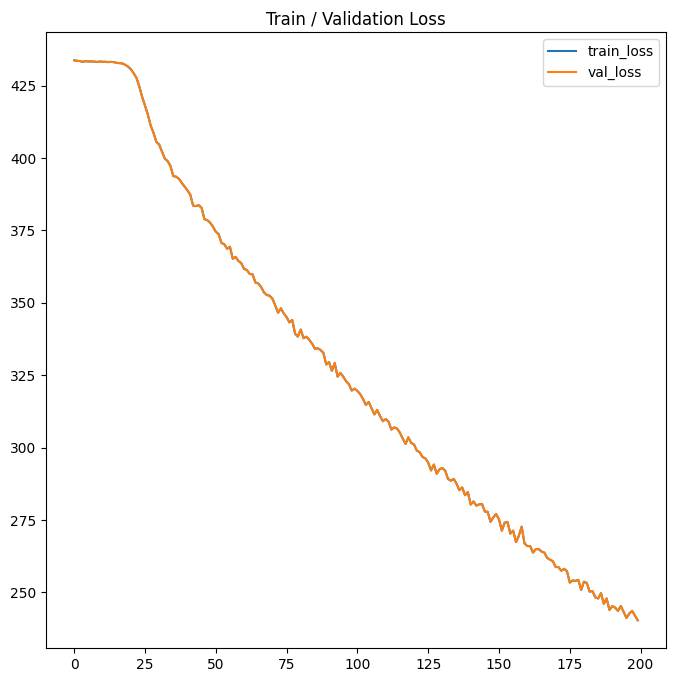

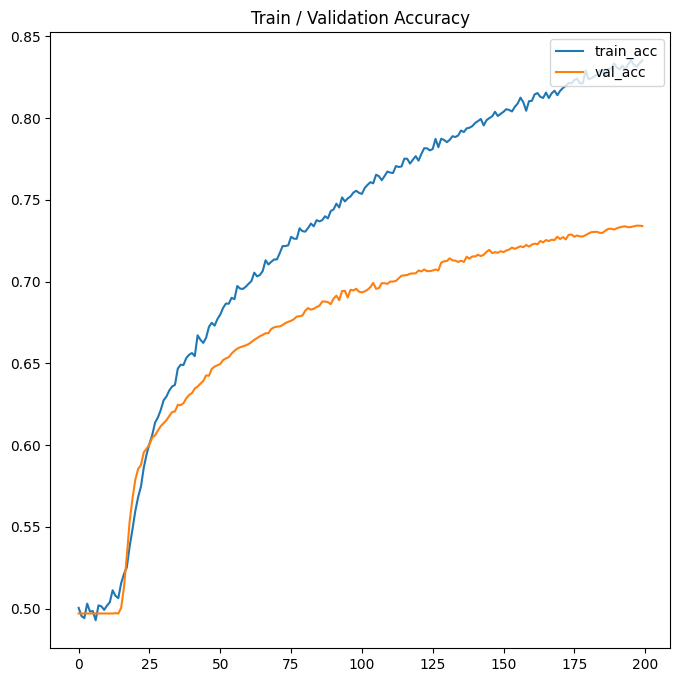

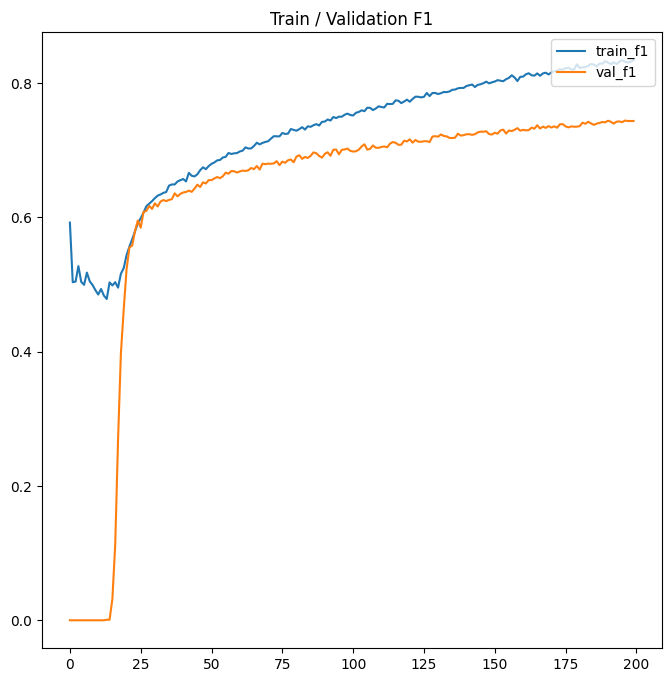

In [26]:
plot_results(history)

In [27]:
test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))

    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]

    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

782it [00:01, 516.00it/s]                         



Test loss: 0.5871135199611838
Test acc: 0.71844
Test f1: 0.7326725152861646


# Interpreting and visualizing the results

In [28]:
def get_attention_scores(model, input_ids):
    """
    This is just a wrapper to easily access attention heads of the last layer
    """

    mask = (input_ids > 0).unsqueeze(1).repeat(1, input_ids.size(1), 1)

    embed = model.nano_bert.embedding(input_ids)

    # can be any layer, and we can also control what to do with output for each layer (aggregate, sum etc.)
    layer = model.nano_bert.encoder.layers[-1]

    x = layer.layer_norm1(embed)

    B, seq_len, n_embed = x.shape

    # if have more than 1 head, or interested in more than 1 head output just add aggregation here
    head = layer.self_attention.heads[0]

    # this is just a part of the single head that does all the computations (same code is present in AttentionHead)
    q = head.query(x)
    k = head.key(x)
    v = head.values(x)

    weights = (q @ k.transpose(-2, -1)) / math.sqrt(n_embed)  # (B, Seq_len, Seq_len)
    weights = weights.masked_fill(mask == 0, -1e9)  # mask out not attended tokens

    scores = F.softmax(weights, dim=-1)

    return scores

In [29]:
test_dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=1)

Val Label Encoding: 100%|██████████| 5000/5000 [00:00<00:00, 1301851.14it/s]


In [30]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the A and B
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    plt.title(f'Attention scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [31]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(test_dataloader.splits['test']):
    if len(v) <= 16:
        examples_ids.append(i)
print(examples_ids)

[1959, 2939, 6394, 15789, 16349, 21487, 22019, 24588]


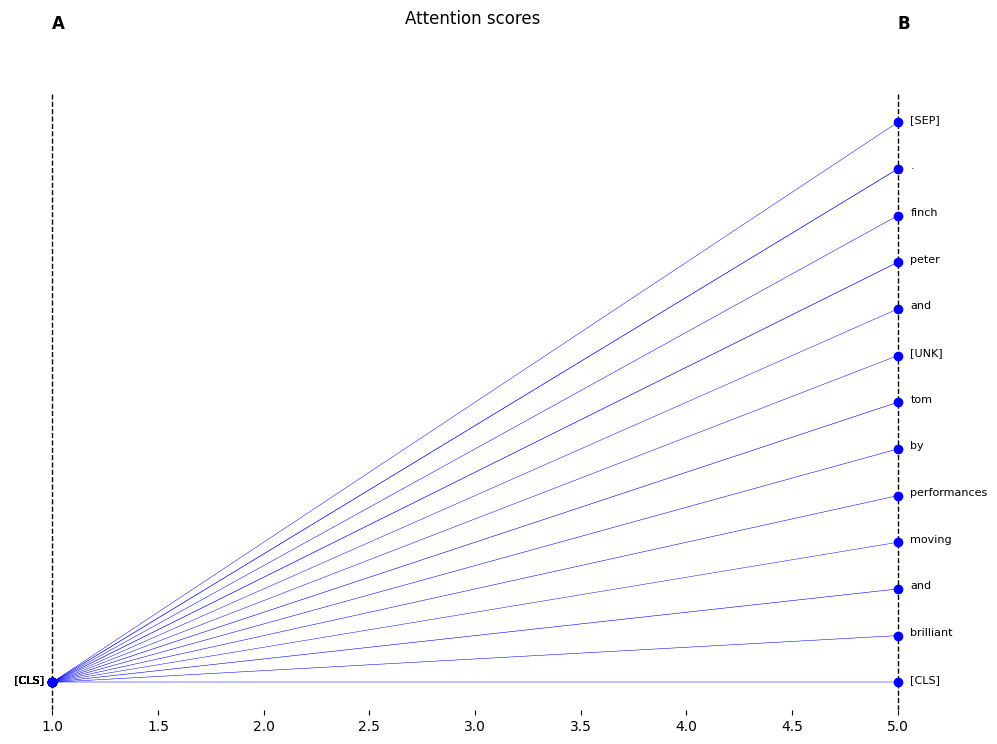

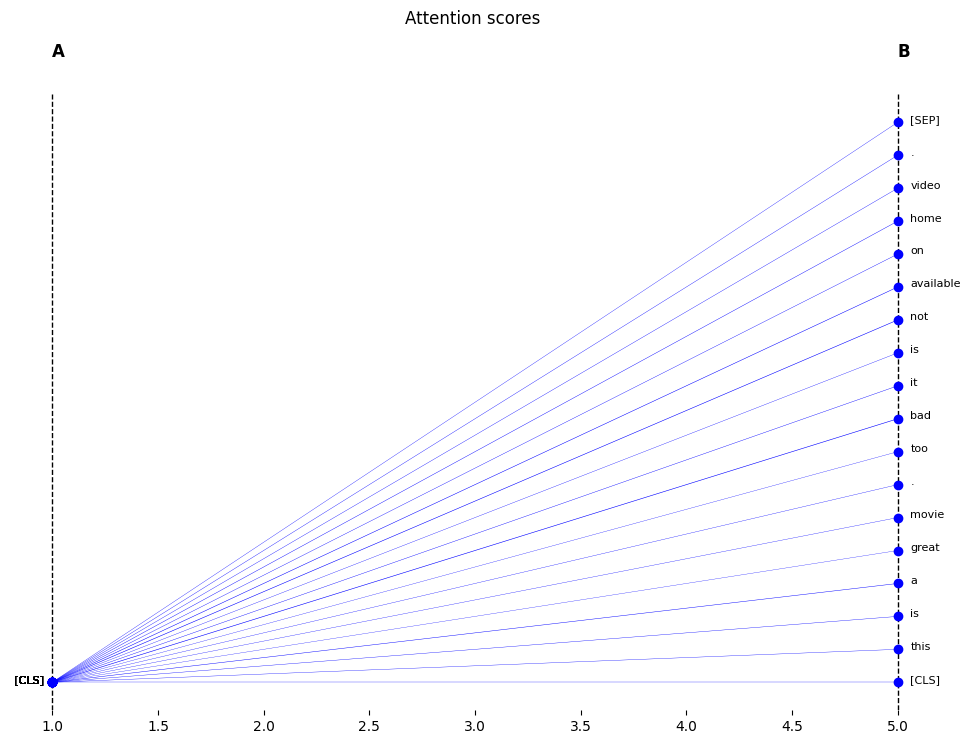

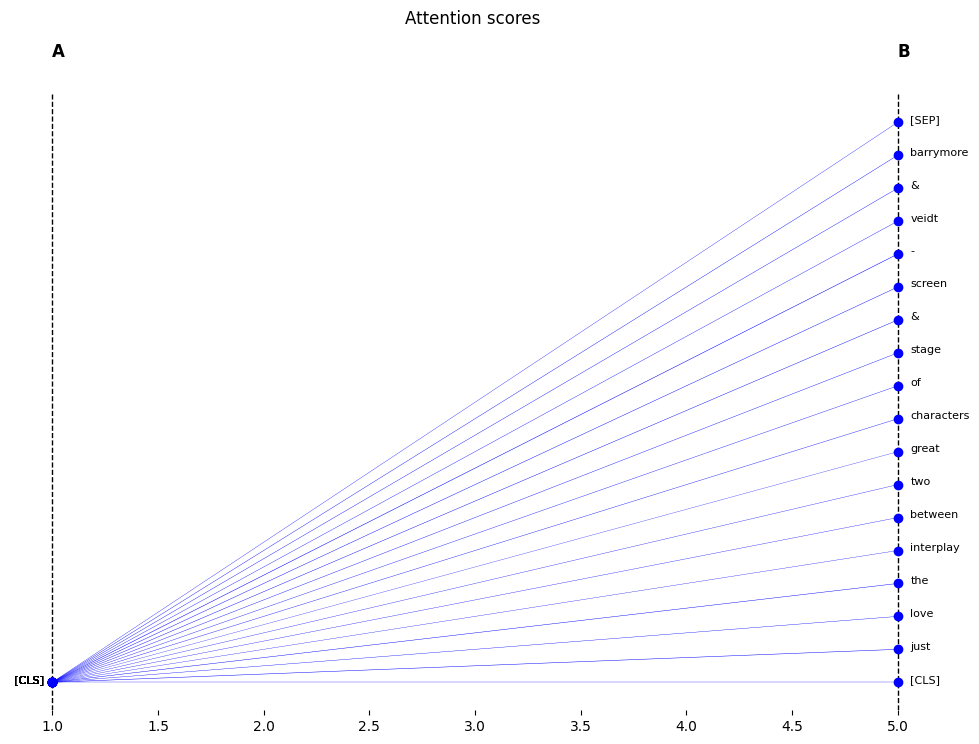

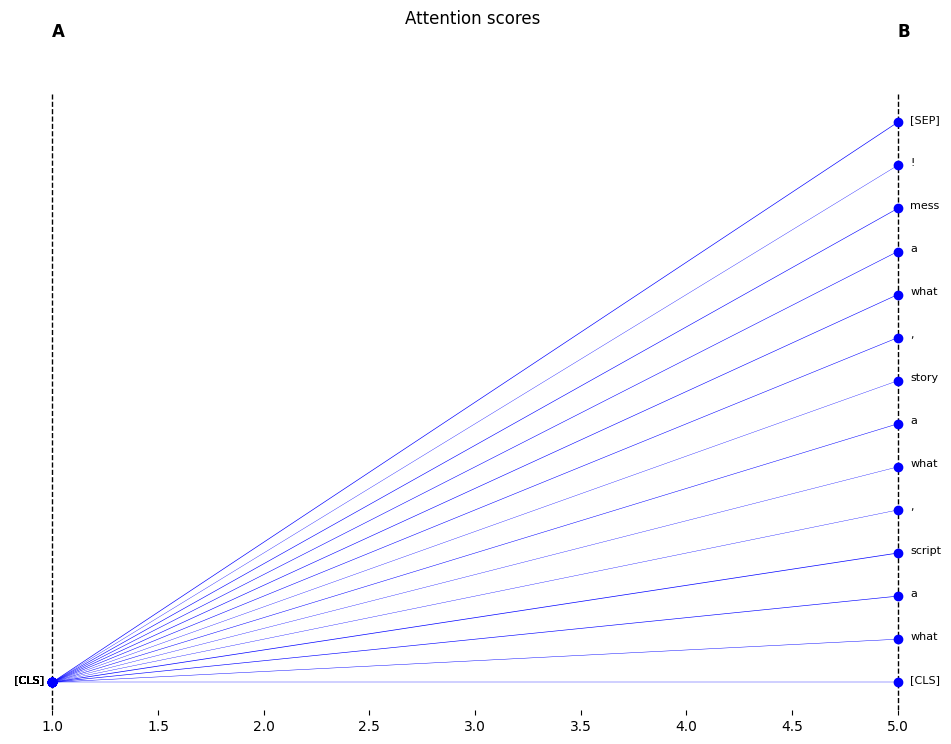

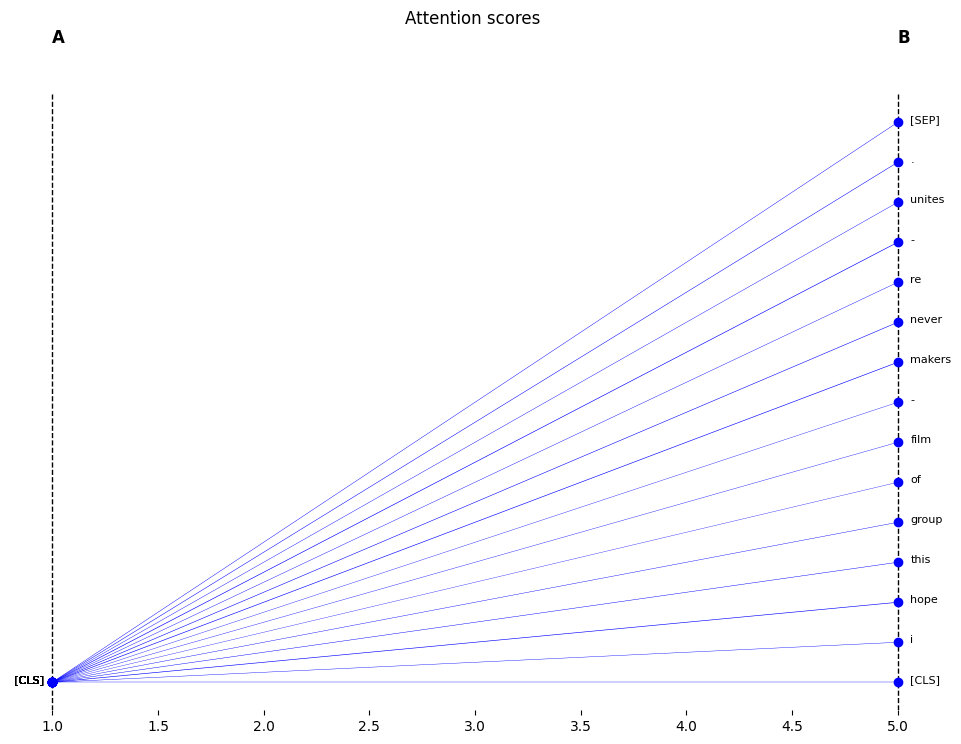

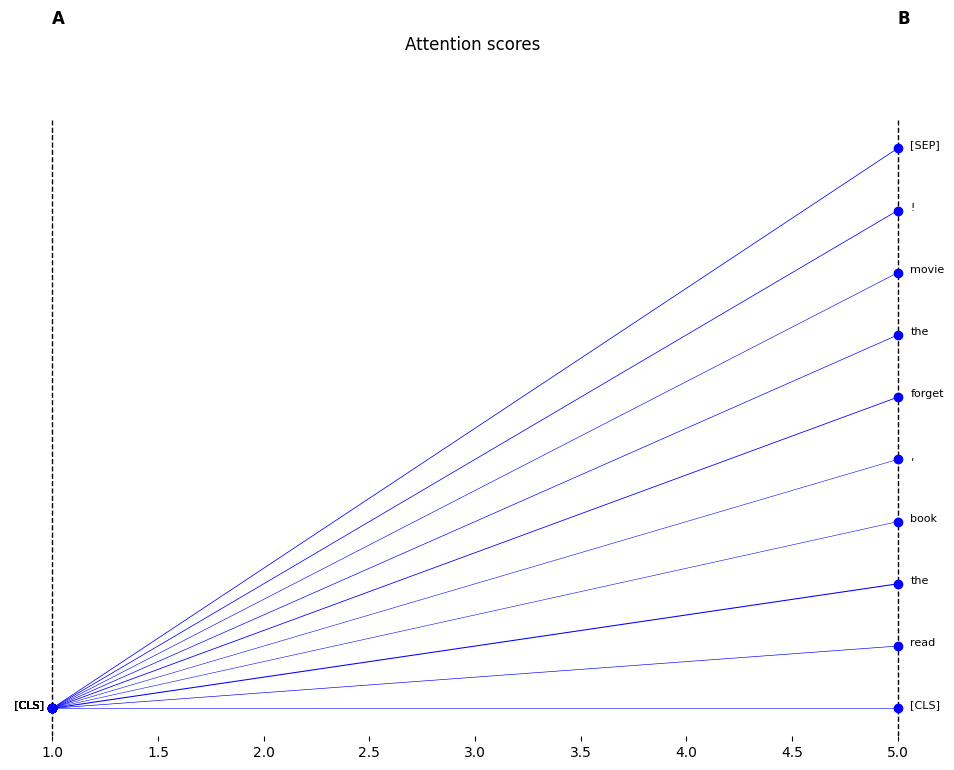

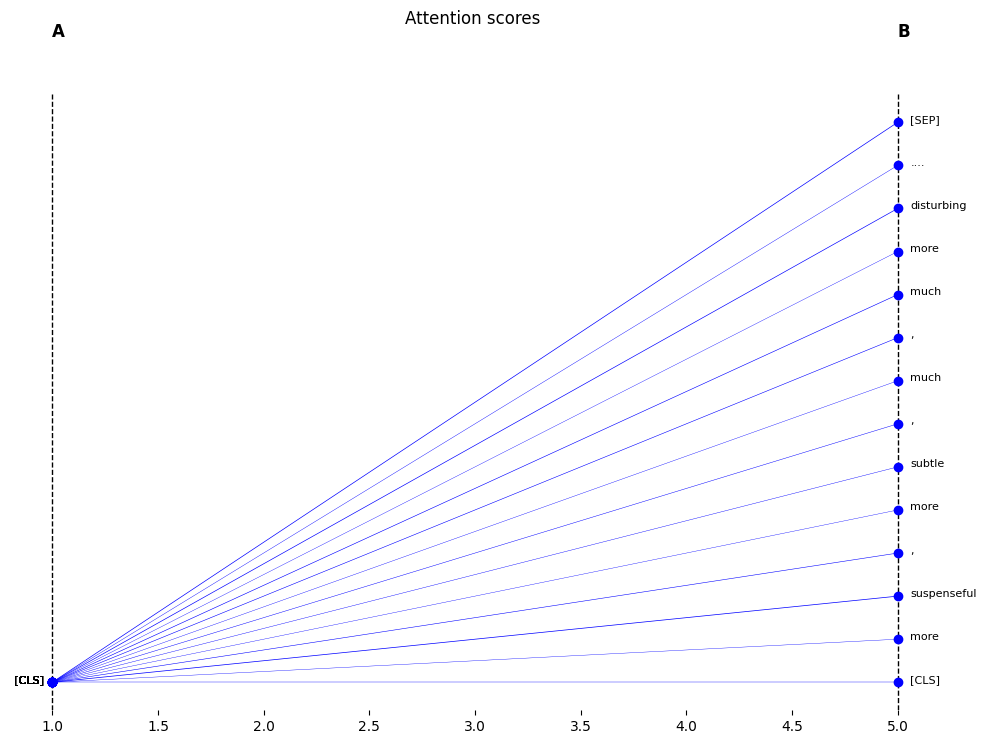

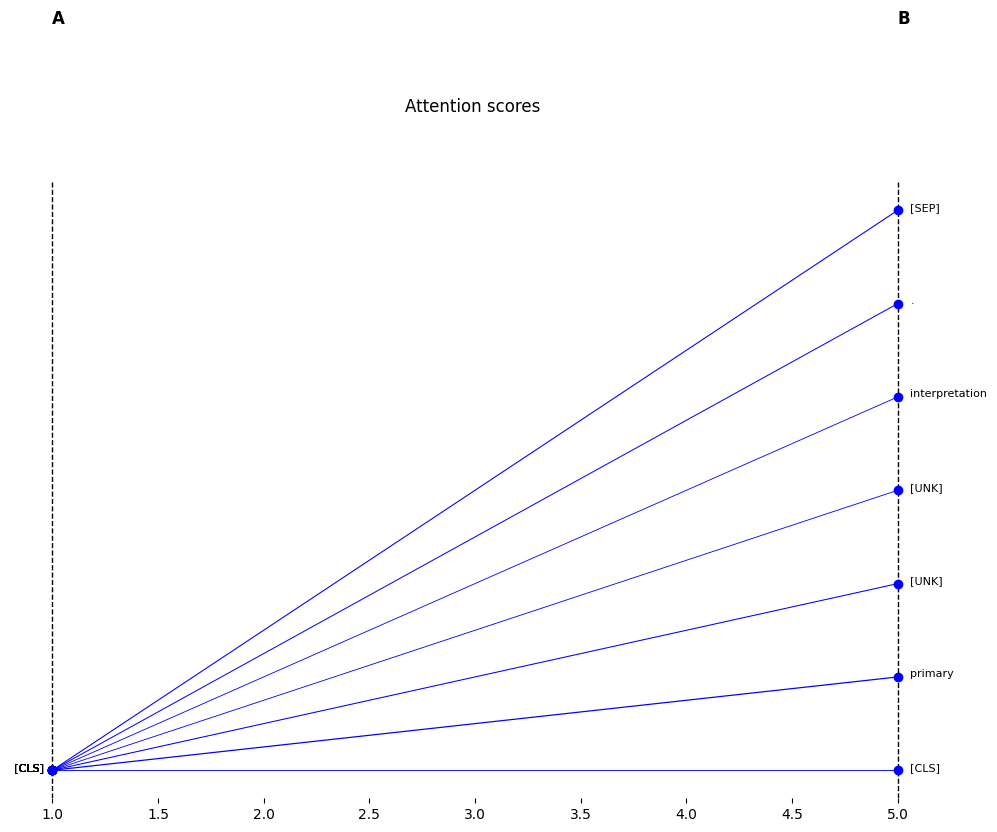

In [32]:
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    # calculate attention scores
    att_matrix = get_attention_scores(bert, test_tokenized_batch['input_ids'].to(device))[0, :seq_len, :seq_len]

    plot_parallel(att_matrix, tokens=tokens)

In [33]:
scatters = []
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    embed = bert.nano_bert.embedding(test_tokenized_batch['input_ids'].to(device))

    x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

    scatters.append(go.Scatter3d(
        x=x, y=y, z=z, mode='markers+text', name=f'Example: {sample_index}',
        text=tokens,
    ))

In [34]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Embeddings')
    ))
fig.show()

In [35]:
scatters = []
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    embed = bert.nano_bert(test_tokenized_batch['input_ids'].to(device))

    x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

    scatters.append(go.Scatter3d(
        x=x, y=y, z=z, mode='markers+text', name=f'Example: {sample_index}',
        text=tokens,
    ))

In [36]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Raw Embeddings')
    ))
fig.show()